# $T_2$ map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.t2 import T2

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the $T_2$ maps NIfTI files we will generate. We will store it in a directory called 
`t2_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2 map
directory = 't2_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve $T_2$ test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.t2_philips(1)
te = te * 1000  # convert TE to ms
mask = image[..., -1] > 50 # Generate a mask based on the signal intensity of the last echo

Compute the $T_2$ maps using the `T2` class implemented in `mapping`.

Multiple models are available to fit data to. `2p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}$ and 
`3p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}+b$ where $b$ is a baseline noise term comprising of 
noise and very long $T_2$ components. Additionally a noise threshold can be specified to ommit late echos when the signal 
has recovered to the noise floor from the fitting process.

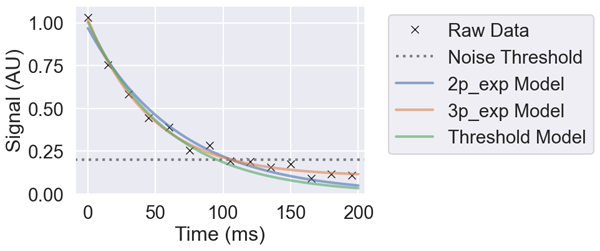

In this tutorial we will compare the `2p_exp` and `3p_exp` models.

In [4]:
# Initialise the mapping objects
mapper_2p = T2(image, te, affine, mask, method='2p_exp')
mapper_3p = T2(image, te, affine, mask, method='3p_exp')

# Save output maps to Nifti
mapper_2p.to_nifti(output_directory=OUTPUT_DIR, base_file_name='two_param_fit', maps='all')
mapper_3p.to_nifti(output_directory=OUTPUT_DIR, base_file_name='three_param_fit', maps='all')

100%|██████████| 33946/33946 [06:42<00:00, 84.25it/s] 
D:\ppxad2\ownCloud\University\Renal Imaging\ukat\ukat\mapping\t2.py:257: RuntimeWarning: divide by zero encountered in reciprocal
  return np.reciprocal(self.t2_map)


Display a central slice of the $T_2$ maps and derived measures.

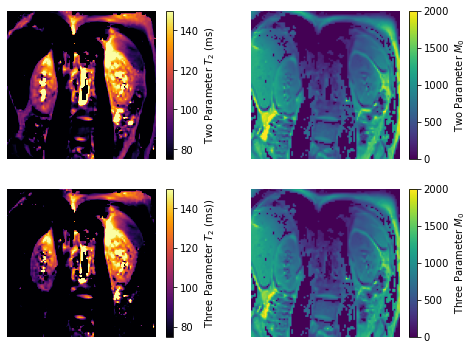

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the two parameter T2 map
im = ax[0, 0].imshow(np.rot90(mapper_2p.t2_map[:, :, 2]), cmap='inferno', clim=(75, 150))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('Two Parameter $T_2$ (ms)')
ax[0, 0].axis('off')

# Display a central slice of the two parameter M0 map
im = ax[0, 1].imshow(np.rot90(mapper_2p.m0_map[:, :, 2]), cmap='viridis', clim=(0, 2000))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('Two Parameter $M_0$')
ax[0, 1].axis('off')

# Display a central slice of the three parameter T2 map
im = ax[1, 0].imshow(np.rot90(mapper_3p.t2_map[:, :, 2]), cmap='inferno', clim=(75, 150))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('Three Parameter $T_2$ (ms))')
ax[1, 0].axis('off')

# Display a central slice of the three parameter M0 map
im = ax[1, 1].imshow(np.rot90(mapper_3p.m0_map[:, :, 2]), cmap='viridis', clim=(0, 2000))
cb = fig.colorbar(im, ax=ax[1, 1])
cb.set_label('Three Parameter $M_0$')
ax[1, 1].axis('off')

plt.show()